In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.utils import class_weight
import os
from datetime import datetime
from glob import glob
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imsave, imread_collection, MultiImage, imshow
%matplotlib inline
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import (
    confusion_matrix, accuracy_score, cohen_kappa_score, 
    classification_report, roc_auc_score, recall_score, precision_score, f1_score)
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam
from keras import regularizers
from keras.models import load_model, Sequential
# from keras.utils import multi_gpu_model
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras
# from keras.applications import ResNet50, inception_v3, resnet50, mobilenet
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
import tensorflow as tf

from keras.regularizers import l1, l2

2023-12-08 14:57:44.096001: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 14:57:44.143154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 14:57:44.143190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 14:57:44.144790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 14:57:44.152527: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 14:57:44.153061: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# utilizar a gpu 0
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

**Importando a base de imagens**

In [3]:
database_classes = glob('database/*/')
n_classes = len(database_classes)
n_files = glob('database/*/*.tif')

labels = np.zeros((len(n_files),n_classes))
images = np.zeros((len(n_files),100,100,3))

cont = 0
lb = 0
for classes in database_classes:
    files_in_classe = glob(classes+'*.tif')
    for fc in files_in_classe:
        labels[cont,lb] = 1
        im = imread(fc)
        image_resized = resize(im, (100,100,3))
        images[cont,:,:,:] = image_resized
        cont+=1
    lb +=1

**Divisão treino/teste**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.3)

In [5]:
print('Tamanho do Treino: ', X_train.shape)
print('Tamanho do Teste: ', X_test.shape)

Tamanho do Treino:  (140, 100, 100, 3)
Tamanho do Teste:  (60, 100, 100, 3)


**Salvar os pesos do melhor modelo**

In [6]:
# now = datetime.now()
# timestamp = datetime.timestamp(now)

checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')


**VGG16**

In [7]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(100,100, 3))

**Congelando as camadas do modelo**

In [8]:
for layer in model.layers:
    layer.trainable = False
    
# for layer in model.layers[15:]:
#     layer.trainable = True

for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x7f222536dab0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f222536ebf0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f21a27b5900>: False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f219caf0c10>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219caf1330>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219caf19f0>: False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f219caf2e30>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219caf37f0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219caf3dc0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219caf3670>: False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f219cb6d750>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f219cb6e020>: False
<keras.src.layers.convolutional.conv

**Configurando a Camada Totalmente Conectada**

In [9]:
headModel = model.output
headModel = Flatten()(headModel)
# headModel = BatchNormalization()(headModel)
headModel = Dense(2048, kernel_regularizer=l2(0.01), kernel_initializer='he_uniform', activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
# headModel = Dense(256, kernel_regularizer=l2(0.01), kernel_initializer='he_uniform', activation="relu")(headModel)
# headModel = Dropout(0.2)(headModel)
headModel = Dense(n_classes, activation='softmax')(headModel)
model = Model(inputs=model.input, outputs=headModel)

**Compilando o modelo**

In [10]:
p_optimizers = Adam(learning_rate=0.0001)
# p_optimizers='SGD'
# p_optimizers = SGD(learning_rate=1e-3, momentum=0.9, decay=1e-3 / 25)

In [11]:
model.compile(loss=categorical_crossentropy, optimizer=p_optimizers, metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=p_optimizers, metrics=['acc'])

**Treinando o modelo**

In [12]:
EPOCHS = 20
BATCH_SIZE = 10

In [13]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.2)
train_generator = ImageDataGenerator().flow(X_train, Y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, Y_validation, batch_size=BATCH_SIZE)

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint],
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/20


/tmp/ipykernel_10396/1309331039.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


11/11 [==============================] - ETA: 0s - loss: 40.5772 - acc: 0.5980
Epoch 1: val_acc improved from -inf to 0.55000, saving model to best_model.h5


/home/rafael/Documentos/IFPI/TOPICOS-ESPECIAIS-M6/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 8s 692ms/step - loss: 40.5772 - acc: 0.5980 - val_loss: 39.1330 - val_acc: 0.5500
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 37.3290 - acc: 0.8727
Epoch 2: val_acc improved from 0.55000 to 0.95000, saving model to best_model.h5
11/11 [==============================] - 7s 681ms/step - loss: 37.3290 - acc: 0.8727 - val_loss: 35.9638 - val_acc: 0.9500
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 34.7462 - acc: 0.9608
Epoch 3: val_acc did not improve from 0.95000
11/11 [==============================] - 7s 613ms/step - loss: 34.7462 - acc: 0.9608 - val_loss: 33.4473 - val_acc: 0.9500
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 32.2727 - acc: 1.0000
Epoch 4: val_acc did not improve from 0.95000
11/11 [==============================] - 7s 591ms/step - loss: 32.2727 - acc: 1.0000 - val_loss: 31.0757 - val_acc: 0.9500
Epoch 5/20
11/11 [==============================] - ETA: 0s - los

**Plotando o historico da acc e loss**

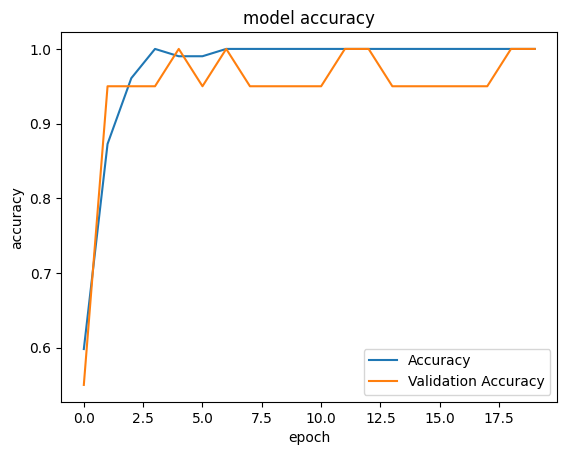

In [14]:
plt.plot(history.history["acc"])
plt.plot(history.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

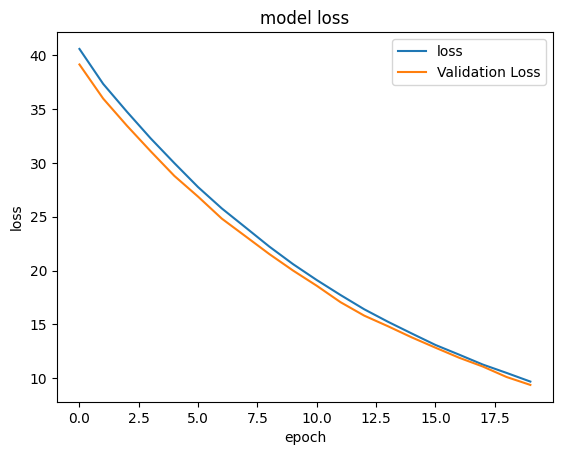

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

**Testando o modelo**

In [16]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 3s 1s/step - loss: 9.4011 - acc: 0.9500
Test loss: 9.401143074035645
Test accuracy: 0.949999988079071


**Carregando o melhor modelo salvo**

In [17]:
model = load_model("./best_model.h5")

In [18]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 3s 1s/step - loss: 28.8474 - acc: 0.9500
Test loss: 28.84740447998047
Test accuracy: 0.949999988079071


In [19]:
test_generator = ImageDataGenerator().flow(X_test, Y_test, shuffle=False)
#, batch_size=BATCH_SIZE

# steps_test = X_test.shape[0]//BATCH_SIZE

In [20]:
test_generator.reset()
pred = model.predict_generator(test_generator, verbose = 1)
pred

/tmp/ipykernel_10396/1067064743.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator, verbose = 1)


2/2 [==============================] - 3s 1s/step


array([[0.01527582, 0.98472416],
       [0.9599204 , 0.0400796 ],
       [0.94315606, 0.05684392],
       [0.00181146, 0.99818856],
       [0.16347803, 0.8365219 ],
       [0.58754486, 0.41245517],
       [0.00327175, 0.99672824],
       [0.06517687, 0.93482304],
       [0.0443465 , 0.9556534 ],
       [0.03861134, 0.96138865],
       [0.01750341, 0.9824966 ],
       [0.01525609, 0.9847439 ],
       [0.10937472, 0.89062524],
       [0.02379296, 0.976207  ],
       [0.03288211, 0.967118  ],
       [0.8596172 , 0.1403828 ],
       [0.9875507 , 0.01244938],
       [0.00435897, 0.99564093],
       [0.5065507 , 0.49344915],
       [0.98148876, 0.01851118],
       [0.00435373, 0.99564624],
       [0.9879163 , 0.01208363],
       [0.9697044 , 0.03029548],
       [0.99144155, 0.00855845],
       [0.05388068, 0.9461193 ],
       [0.01931717, 0.9806828 ],
       [0.980711  , 0.01928898],
       [0.95330584, 0.04669421],
       [0.98814434, 0.01185574],
       [0.9829145 , 0.01708547],
       [0.

In [21]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [22]:
# y_true = Y_test[:,-1]
y_true = np.argmax(Y_test, axis=1)
y_true

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

**Calculando várias métricas**

In [23]:
def calc_metrics(y_pred, y_true):
    acc = accuracy_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = (1.0 * tn) / (tn + fp)
    sensitivity = (1.0 * tp) / (tp + fn)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(y_true, y_pred,average="macro")
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    
    print('accuracy: ', acc*100)
    print('specificity: ', specificity*100)
    print('specificity: ', sensitivity*100)
    print('kappa: {}'.format(kappa*100))
    print('f1-score: {}'.format(f1*100))
    print('AUC: {}'.format(auc_score*100))
    print('recall: {}'.format(recall*100))
    print('precision: {}'.format(precision*100))    
    print('Confusion Matriz:\n', confusion_matrix(y_true, y_pred))
    
    metrics = np.round([acc, specificity, sensitivity, kappa, f1, auc_score, recall, precision], 4)
    return metrics

In [24]:
metrics = calc_metrics(y_pred, y_true)
metrics

accuracy:  95.0
specificity:  96.15384615384616
specificity:  94.11764705882352
kappa: 89.86486486486487
f1-score: 94.93100535060547
AUC: 95.13574660633485
recall: 95.13574660633483
precision: 94.78114478114479
Confusion Matriz:
 [[25  1]
 [ 2 32]]


array([0.95  , 0.9615, 0.9412, 0.8986, 0.9493, 0.9514, 0.9514, 0.9478])